In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer_ELMo+Embeddings
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer-ft_ELMo
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer-ft_ELMo+CNN+Embeddings
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer-ft_ELMo+CNN
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer_ELMo+CNN+Embeddings
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer-ft_ELMo+Embeddings
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer_ELMo
/opt/models/elmo/ner/results (pre queda energia, datalawyer)/datalawyer_ELMo+CNN


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

32
32


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 3:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', EXECUTION_NUMBER: data[2]}
    elif len(data) == 4:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], EXECUTION_NUMBER: data[4]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'ELMo+Embeddings', 'fasttext', 'skip', '0']
['datalawyer', 'ELMo+Embeddings', 'fasttext', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'wang2vec', 'skip', '0']
['datalawyer', 'ELMo+Embeddings', 'word2vec', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'wang2vec', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'glove', '0']
['datalawyer', 'ELMo+Embeddings', 'word2vec', 'skip', '0']
['datalawyer-ft', 'ELMo', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove', '0']
['datalawyer-ft', 'ELMo+CNN', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0']
['datalawyer', 'EL

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_ELMo+Embeddings_fasttext_skip_0,datalawyer,ELMo+Embeddings,fasttext,skip,NaN,0,14,20,01:24:14,5054.0,252.70,0.996089,0.996223,0.950953,0.952816,0.951884,6.421366,0.987460,0.987941,0.880089,0.895331,0.887645,32.009712,0.987502,0.988118,0.852559,0.874608,0.863443,40.250551
1,datalawyer_ELMo+Embeddings_fasttext_cbow_0,datalawyer,ELMo+Embeddings,fasttext,cbow,NaN,0,15,20,01:21:41,4901.0,245.05,0.992857,0.993192,0.917198,0.915102,0.916149,11.220935,0.987959,0.988366,0.888054,0.890060,0.889056,25.840158,0.986745,0.987309,0.856923,0.873041,0.864907,32.920424
2,datalawyer_ELMo+Embeddings_wang2vec_skip_0,datalawyer,ELMo+Embeddings,wang2vec,skip,NaN,0,9,20,01:20:22,4822.0,241.10,0.996085,0.996250,0.954731,0.953796,0.954263,6.287366,0.987238,0.987589,0.873446,0.899096,0.886085,31.252086,0.987133,0.987573,0.848714,0.879310,0.863741,36.833743
3,datalawyer_ELMo+Embeddings_word2vec_cbow_0,datalawyer,ELMo+Embeddings,word2vec,cbow,NaN,0,9,20,01:20:57,4857.0,242.85,0.996404,0.996546,0.957579,0.958204,0.957891,6.124068,0.986831,0.987220,0.871681,0.890060,0.880775,35.672906,0.986640,0.987203,0.844394,0.867555,0.855818,41.391425
4,datalawyer_ELMo+Embeddings_wang2vec_cbow_0,datalawyer,ELMo+Embeddings,wang2vec,cbow,NaN,0,9,20,01:25:11,5111.0,255.55,0.996150,0.996296,0.957068,0.957224,0.957146,6.519314,0.987478,0.987756,0.875735,0.896837,0.886161,32.079471,0.986516,0.987080,0.846271,0.871473,0.858687,37.550806
5,datalawyer_ELMo+Embeddings_glove_0,datalawyer,ELMo+Embeddings,glove,No,NaN,0,11,20,01:31:37,5497.0,274.85,0.996265,0.996404,0.953568,0.955592,0.954579,6.221952,0.988607,0.989069,0.896055,0.889307,0.892668,31.777267,0.985883,0.986622,0.858034,0.862069,0.860047,42.737283
6,datalawyer_ELMo+Embeddings_word2vec_skip_0,datalawyer,ELMo+Embeddings,word2vec,skip,NaN,0,13,20,01:20:52,4852.0,242.60,0.996577,0.996711,0.958564,0.959347,0.958956,5.754232,0.987183,0.987478,0.871982,0.897590,0.884601,34.647796,0.986780,0.987309,0.841509,0.873824,0.857363,40.853081
7,datalawyer-ft_ELMo_0,datalawyer-ft,ELMo,No,No,NaN,0,17,20,1:29:06.965009,5346.0,267.30,0.996784,0.996907,0.965033,0.964245,0.964639,5.799219,0.986831,0.987164,0.872875,0.889307,0.881015,41.361886,0.986340,0.986904,0.851259,0.874608,0.862775,46.262572
8,datalawyer-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0,datalawyer-ft,ELMo+CNN+Embeddings,wang2vec,cbow,NaN,0,11,20,01:34:41,5681.0,284.05,0.997111,0.997199,0.969266,0.968000,0.968633,4.979233,0.987090,0.987515,0.895019,0.879518,0.887201,40.891018,0.986728,0.987256,0.877291,0.862853,0.870012,46.374493
9,datalawyer-ft_ELMo+CNN+Embeddings_fasttext_cbow_0,datalawyer-ft,ELMo+CNN+Embeddings,fasttext,cbow,NaN,0,9,20,01:32:15,5535.0,276.75,0.993975,0.994256,0.934722,0.930449,0.932581,8.851333,0.986887,0.987164,0.873622,0.895331,0.884344,28.907919,0.986516,0.987097,0.843063,0.871473,0.857033,33.769151


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:30:40.437500'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_datalawyer_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
datalawyer-ft,16.0,85.775406,0.567289,84.874275,0.854564,0.857480,0.861054,87.001185
datalawyer,16.0,85.730995,0.495273,84.787645,0.854529,0.857528,0.860653,86.490683


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,14.0,85.826037,0.518002,84.874275,0.856176,0.859073,0.862594,86.490683
ELMo+CNN+Vetor,14.0,85.713726,0.505047,84.787645,0.855006,0.856977,0.857786,87.001185
ELMo,2.0,85.637807,0.904722,84.998072,0.853179,0.856378,0.859577,86.277542
ELMo+CNN,2.0,85.635064,0.865530,85.023041,0.853291,0.856351,0.859411,86.247086


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
CBoW,12.0,85.917498,0.463294,85.179407,0.856977,0.858191,0.859952,87.001185
Skip-Gram,12.0,85.656811,0.554047,84.787645,0.853133,0.857142,0.859220,86.448598
Sem Vetor,8.0,85.651339,0.569003,84.998072,0.850600,0.857424,0.861426,86.277542


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Word2Vec,8.0,85.853663,0.283623,85.581755,0.857142,0.857534,0.858621,86.448598
Wang2Vec,8.0,85.772187,0.683949,84.874275,0.853235,0.857155,0.860530,87.001185
FastText,8.0,85.735613,0.566873,84.787645,0.855538,0.857363,0.860552,86.490683
GloVe,4.0,85.666242,0.481977,85.072353,0.853782,0.857424,0.860305,86.107832
Sem Vetor,4.0,85.636435,0.722881,84.998072,0.850168,0.856351,0.862547,86.277542


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino   Representação  Vetor     Tipo de Vetor                        
datalawyer-ft ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  87.001185   
datalawyer    ELMo+Vetor     FastText  CBoW                1.0  86.490683   
datalawyer-ft ELMo+Vetor     Word2Vec  Skip-Gram           1.0  86.448598   
datalawyer    ELMo+Vetor     Wang2Vec  Skip-Gram           1.0  86.374134   
                             FastText  Skip-Gram           1.0  86.344294   
datalawyer-ft ELMo           Sem Vetor Sem Vetor           1.0  86.277542   
datalawyer    ELMo+CNN       Sem Vetor Sem Vetor           1.0  86.247086   
datalawyer-ft ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  86.107832   
                             Word2Vec  CBoW                1.0  86.104606   
datalawyer    ELMo+Vetor     GloVe     Sem Vetor           1.0  86.004691   
datalawyer-ft ELMo+Vetor     FastText  CBoW                1.0  85.958771   
                             Wang2Vec  CBoW                1.0  85.945946   
datalawyer    ELMo+Vetor     Wang2Vec  CBoW                1.0  85.868726   
              ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  85.781250   
datalawyer-ft ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  85.770595   
datalawyer    ELMo+CNN+Vetor FastText  CBoW                1.0  85.769379   
              ELMo+Vetor     Word2Vec  Skip-Gram           1.0  85.736255   
datalawyer-ft ELMo+Vetor     Word2Vec  CBoW                1.0  85.725309   
              ELMo+CNN+Vetor FastText  CBoW                1.0  85.703276   
                                       Skip-Gram           1.0  85.692129   
datalawyer    ELMo+CNN+Vetor Word2Vec  CBoW                1.0  85.680934   
              ELMo+Vetor     Word2Vec  CBoW                1.0  85.581755   
datalawyer-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.0  85.562310   
datalawyer    ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  85.480094   
                             Wang2Vec  Skip-Gram           1.0  85.371517   
                                       CBoW                1.0  85.179407   
datalawyer-ft ELMo+Vetor     FastText  Skip-Gram           1.0  85.138731   
                             GloVe     Sem Vetor           1.0  85.072353   
              ELMo+CNN       Sem Vetor Sem Vetor           1.0  85.023041   
datalawyer    ELMo           Sem Vetor Sem Vetor           1.0  84.998072   
datalawyer-ft ELMo+Vetor     Wang2Vec  Skip-Gram           1.0  84.874275   
datalawyer    ELMo+CNN+Vetor FastText  Skip-Gram           1.0  84.787645   

                                                      Desvio Padrão  \
Ajuste Fino   Representação  Vetor     Tipo de Vetor                  
datalawyer-ft ELMo+CNN+Vetor Wang2Vec  CBoW                     NaN   
datalawyer    ELMo+Vetor     FastText  CBoW                     NaN   
datalawyer-ft ELMo+Vetor     Word2Vec  Skip-Gram                NaN   
datalawyer    ELMo+Vetor     Wang2Vec  Skip-Gram                NaN   
                             FastText  Skip-Gram                NaN   
datalawyer-ft ELMo           Sem Vetor Sem Vetor                NaN   
datalawyer    ELMo+CNN       Sem Vetor Sem Vetor                NaN   
datalawyer-ft ELMo+CNN+Vetor GloVe     Sem Vetor                NaN   
                             Word2Vec  CBoW                     NaN   
datalawyer    ELMo+Vetor     GloVe     Sem Vetor                NaN   
datalawyer-ft ELMo+Vetor     FastText  CBoW                     NaN   
                             Wang2Vec  CBoW                     NaN   
datalawyer    ELMo+Vetor     Wang2Vec  CBoW                     NaN   
              ELMo+CNN+Vetor Word2Vec  Skip-Gram                NaN   
datalawyer-ft ELMo+CNN+Vetor Word2Vec  Skip-Gram                NaN   
datalawyer    ELMo+CNN+Vetor FastText  CBoW                     NaN   
              ELMo+Vetor     Word2Vec  Skip-Gram                NaN   
datalawyer-ft ELMo+Vetor     Word2Vec  CBoW                     NaN   
              E

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
wang2vec  cbow              4.0  0.859988  0.007519  0.851794  0.856964   
fasttext  cbow              4.0  0.859805  0.003569  0.857033  0.857529   
word2vec  skip              4.0  0.859342  0.003435  0.857363  0.857620   
          cbow              4.0  0.857732  0.002290  0.855818  0.856561   
glove     No                4.0  0.856662  0.004820  0.850724  0.853782   
No        No                4.0  0.856364  0.007229  0.849981  0.850168   
wang2vec  skip              4.0  0.855456  0.006239  0.848743  0.852472   
fasttext  skip              4.0  0.854907  0.006800  0.847876  0.850510   

                               50%       75%       max  
Embedding Embedding_Type                                
wang2vec  cbow            0.859073  0.862098  0.870012  
fasttext  cbow            0.858641  0.860917  0.864907  
word2vec  skip            0.857759  0.859481  0.864486  
          cbow            0.857031  0.858201  0.861046  
glove     No              0.857424  0.860305  0.861078  
No        No              0.856351  0.862547  0.862775  
wang2vec  skip            0.854669  0.857653  0.863741  
fasttext  skip            0.854154  0.858552  0.863443

In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec,4.0,0.859342,0.003435,0.857363,0.857620,0.857759,0.859481,0.864486
glove,4.0,0.856662,0.004820,0.850724,0.853782,0.857424,0.860305,0.861078
No,4.0,0.856364,0.007229,0.849981,0.850168,0.856351,0.862547,0.862775
wang2vec,4.0,0.855456,0.006239,0.848743,0.852472,0.854669,0.857653,0.863741
fasttext,4.0,0.854907,0.006800,0.847876,0.850510,0.854154,0.858552,0.863443


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,4.0,0.859988,0.007519,0.851794,0.856964,0.859073,0.862098,0.870012
fasttext,4.0,0.859805,0.003569,0.857033,0.857529,0.858641,0.860917,0.864907
word2vec,4.0,0.857732,0.002290,0.855818,0.856561,0.857031,0.858201,0.861046
glove,4.0,0.856662,0.004820,0.850724,0.853782,0.857424,0.860305,0.861078
No,4.0,0.856364,0.007229,0.849981,0.850168,0.856351,0.862547,0.862775


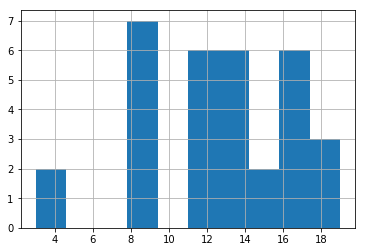

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count      32.000000
mean     5440.437500
std       543.281483
min      4751.000000
25%      5103.750000
50%      5319.000000
75%      5672.750000
max      7480.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
0,32.0,0.857532,0.005243,0.847876,0.854529,0.857528,0.861054,0.870012


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,32.0,0.857532,0.005243,0.000927,0.855642,0.859422


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in sqrt
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in sqrt
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,4,0.856364,0.007229,0.003614,0.849280,0.863449
fasttext,8,0.857356,0.005669,0.002004,0.853428,0.861284
glove,4,0.856662,0.004820,0.002410,0.851939,0.861386
wang2vec,8,0.857722,0.006839,0.002418,0.852982,0.862461
word2vec,8,0.858537,0.002836,0.001003,0.856571,0.860502


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 27) =  0.138, p =  0.96668762837419452971
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                    0.1381
Date:                Sun, 02 Jun 2019   Prob (F-statistic):              0.967
Time:                        21:10:29   Log-Likelihood:                 123.45
No. Observations:                  32   AIC:                            -236.9
Df Residuals:                      27   BIC:                            -229.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------